# 線形代数-linalg

NumPyとSciPyはどちらも線形代数関数ライブラリ`linalg`を提供していますが、SciPyの線形代数ライブラリはNumPyよりも包括的です。

In [14]:
from matplotlib import pyplot as plt
import helper.matplotlib
import helper.magics
import numpy as np
from scipy import linalg

## 線形方程式の解法

`numpy.linalg.solve(A, b)`と`scipy.linalg.solve(A, b)`は、線形方程式$\mathbf{A} \mathbf{x} = \mathbf{b}$を解くために使用できます。つまり、$\mathbf{x}=\mathbf{A}^{-1} \mathbf{b}$を計算します。ここで、$\mathbf{A}$は$m \times m$の正方行列であり、$\mathbf{x}$と$\mathbf{b}$は長さ$m$のベクトルです。時々、$\mathbf{A}$が固定されており、複数の$\mathbf{b}$に対して解を求める必要があるため、2番目の引数は$m \times n$の行列$\mathbf{B}$でもかまいません。この場合、計算される$\mathbf{X}$も$m \times n$の行列になります。これは$\mathbf{A}^{-1} \mathbf{B}$を計算することに相当します。

いくつかの行列式では、$\mathbf{A}^{-1} \mathbf{B}$のような演算が頻繁に現れますが、これらはすべて`solve(A,B)`で計算できます。これは逆行列を直接計算して行列乗算を行うよりも高速です。以下のプログラムは`solve()`と逆行列の計算速度を比較しています：

In [8]:
import numpy as np
from scipy import linalg

m, n = 500, 50
A = np.random.rand(m, m)
B = np.random.rand(m, n)
X1 = linalg.solve(A, B)
X2 = np.dot(linalg.inv(A), B)
print(np.allclose(X1, X2))
%timeit linalg.solve(A, B)
%timeit np.dot(linalg.inv(A), B)

True
57.2 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


複数の$\mathbf{B}$に対して解を求める必要があるが、それらを1つの行列にまとめることが難しい場合、例えば、いくつかの行列式では$\mathbf{A}^{-1} \mathbf{B}$、$\mathbf{A}^{-1} \mathbf{C}$、$\mathbf{A}^{-1} \mathbf{D}$などの乗算が現れることがありますが、$\mathbf{B}$、$\mathbf{C}$、$\mathbf{D}$は何らかの方法で逐次計算されます。この場合、`lu_factor()`と`lu_solve()`を使用できます。まず、`lu_factor(A)`を呼び出して行列$\mathbf{A}$をLU分解し、タプル（LU行列、ソート配列）を取得します。このタプルを`lu_solve()`に渡すことで、異なる$\mathbf{B}$に対して解を求めることができます。$\mathbf{A}$が既にLU分解されているため、`lu_solve()`はすぐに結果を得ることができます。

In [9]:
luf = linalg.lu_factor(A)
X3 = linalg.lu_solve(luf, B)
np.allclose(X1, X3)

True

`lu_factor()`と`lu_solve()`を使用する代わりに、`inv()`を使用して逆行列を計算し、行列積を計算することもできます。以下の比較では、`lu_factor()`が`inv()`よりもはるかに高速であり、`lu_solve()`と行列積の計算速度がほぼ同じであることがわかります：

In [10]:
M, N = 1000, 100
np.random.seed(0)
A = np.random.rand(M, M)
B = np.random.rand(M, N)
Ai = linalg.inv(A)
luf = linalg.lu_factor(A)
%timeit linalg.inv(A)
%timeit Ai @ B
%timeit linalg.lu_factor(A)
%timeit linalg.lu_solve(luf, B)

75.4 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.42 ms ± 56.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
60.3 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.14 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 最小二乗解

`lstsq()`は`solve()`よりも一般的であり、行列$\mathbf{A}$が正方行列である必要はありません。つまり、方程式の数は未知数の数よりも少なくても、等しくても、多くてもかまいません。これは、$\left \| \mathbf{b}-\mathbf{A} \cdot \mathbf{x} \right \|$が最小になるような解$\mathbf{x}$を見つけます。得られた結果を最小二乗解と呼び、すべての等式の誤差の二乗和が最小になるようにします。以下では、離散畳み込みの逆演算を解く例として、`lstsq()`の使用方法を紹介します。

まず、離散畳み込みに関する基本的な知識と計算方法を簡単に紹介します。離散線形時不変システム$\mathbf{h}$に対して、入力が$\mathbf{x}$の場合、出力$\mathbf{y}$は$\mathbf{x}$と$\mathbf{h}$の畳み込みで表されます：$\mathbf{y} = \mathbf{x} * \mathbf{h}$。離散畳み込みの計算式は以下の通りです：

$$y[n] = \sum h[m]\ x[n-m]$$
    
$\mathbf{h}$の長さが$n$、$\mathbf{x}$の長さが$m$の場合、畳み込み計算によって得られる$\mathbf{y}$の長さは$n+m-1$になります。その各値は以下の式に従って計算されます：

```
y[0] = h[0]*x[0]
y[1] = h[0]*x[1] + h[1]*x[0]
y[2] = h[0]*x[2] + h[1]*x[1] + h[2]*x[0]
y[3] = h[0]*x[3] + h[1]*x[2] + h[2]*x[1]
...
y[n+m-1] = h[n-1]*x[m-1]   
```

畳み込みの逆演算とは、$\mathbf{x}$と$\mathbf{y}$が既知の場合に$\mathbf{h}$を求めることです。$\mathbf{h}$の長さが$n$であるため、$n$個の未知数があり、$\mathbf{y}$の長さが$n+m-1$であるため、これらの$n$個の未知数は$n+m-1$個の線形方程式を満たす必要があります。方程式の数が未知数の数よりも多いため、畳み込みの逆演算には正確な解が存在しない場合があり、問題は$\mathbf{x} * \mathbf{h}$と$\mathbf{y}$の間の誤差が最小になるような$\mathbf{h}$を見つけることになります。明らかに、これは最小二乗解です。以下のプログラムは、`lstsq()`を使用して畳み込みの逆演算を計算する方法を示しています：

❶まず、`make_data()`は必要なデータを作成し、ランダム数関数`standard_normal()`を使用して配列$\mathbf{x}$と$\mathbf{h}$を初期化します。実際のシステムでは、$\mathbf{h}$は通常未知であり、値は徐々に減衰します。`make_data()`はシステムの入力信号`x`とランダムノイズを追加した出力信号`yn`を返します。最小二乗法の結果と比較するために、システムの係数`h`も出力します。

❷`solve_h()`は最小二乗法を使用してシステムのパラメータ`h`を計算します。通常、未知のシステムの係数の長さはわからないため、ここではNを求める係数の長さとして使用します。

前述の畳み込み方程式系を観察すると、$n+m-1$個の方程式のうち、中央の$m-n+1$個の方程式はhのすべての係数を使用しています。プログラムの計算を容易にするために、これらの$m-n+1$個の方程式に対して最小二乗演算を行います。❸`h`の長さに応じて、1次元配列`x`を形状`(m-n+1, n)`の2次元配列`X`に変換する必要があります。この2次元配列は`as_strided()`を使用して簡単に取得できます。❹出力配列`y`から、配列`X`の各行に対応する部分を取り出し、❺`lstsq()`を呼び出してこれらの$m-n+1$個の方程式に対して最小二乗演算を行います。❻`lstsq()`はタプルを返し、その0番目の要素は最小二乗解です。得られた結果の順序は逆順であるため、それを反転させる必要があります。

In [11]:
from numpy.lib.stride_tricks import as_strided


def make_data(m, n, noise_scale):  # ❶
    np.random.seed(42)
    x = np.random.standard_normal(m)
    h = np.random.standard_normal(n)
    y = np.convolve(x, h)
    yn = y + np.random.standard_normal(len(y)) * noise_scale * np.max(y)
    return x, yn, h


def solve_h(x, y, n):  # ❷
    X = as_strided(x, shape=(len(x) - n + 1, n), strides=(x.itemsize, x.itemsize))  # ❸
    Y = y[n - 1 : len(x)]  # ❹
    h = linalg.lstsq(X, Y)  # ❺
    return h[0][::-1]  # ❻

次に、長さ100の未知のシステム係数`h`に対して、長さ80と120の最小二乗解をそれぞれ計算します。システムの出力にいくつかのノイズ信号を追加しているため、これらは完全には一致しません。次のグラフは、これらの解と実際の係数を比較しています。

In [12]:
x, yn, h = make_data(1000, 100, 0.4)
H1 = solve_h(x, yn, 120)
H2 = solve_h(x, yn, 80)

print("Average error of H1:", np.mean(np.abs(H1[:100] - h)))
print("Average error of H2:", np.mean(np.abs(h[:80] - H2)))

Average error of H1: 0.3015488540440349
Average error of H2: 0.2958422158342372


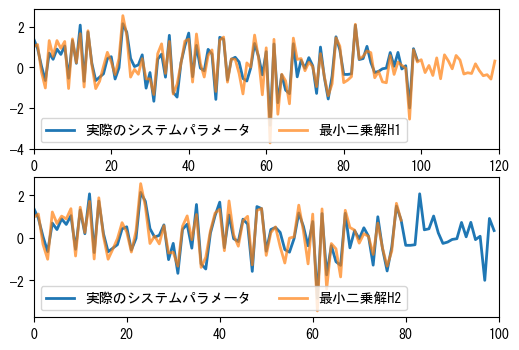

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))
ax1.plot(h, linewidth=2, label="実際のシステムパラメータ")
ax1.plot(H1, linewidth=2, label="最小二乗解H1", alpha=0.7)
ax1.legend(loc="best", ncol=2)
ax1.set_xlim(0, len(H1))

ax2.plot(h, linewidth=2, label="実際のシステムパラメータ")
ax2.plot(H2, linewidth=2, label="最小二乗解H2", alpha=0.7)
ax2.legend(loc="best", ncol=2)
ax2.set_xlim(0, len(h));

## 固有値と固有ベクトル

$n\times n$の行列$\mathbf{A}$は、$n$次元空間における線形変換と見なすことができます。$\mathbf{x}$が$n$次元空間内のベクトルである場合、$\mathbf{A}$と$\mathbf{x}$の行列積は、$\mathbf{x}$を線形変換した後のベクトルです。$\mathbf{x}$が線形変換の固有ベクトルである場合、この線形変換の後、新しいベクトルは元の$\mathbf{x}$と同じ方向を保ちますが、その長さは変化するかもしれません。固有ベクトルの長さがこの線形変換下でスケーリングされる比率を固有値と呼びます。つまり、固有ベクトル$\mathbf{x}$は以下の等式を満たし、$\lambda$の値は任意の複素数です：

$$\mathbf{A} \mathbf{x} = \lambda \mathbf{x}$$

以下では、2次元平面上の線形変換行列を例として、固有値と固有ベクトルの幾何学的な意味を説明します。`linalg.eig(A)`を使用して行列`A`の2つの固有値`evalues`と固有ベクトル`evectors`を計算します。`evectors`では、各列が1つの固有ベクトルです。

In [15]:
A = np.array([[1, -0.3], [-0.1, 0.9]])
evalues, evectors = linalg.eig(A)
%C evalues; evectors

            evalues                         evectors          
--------------------------------  ----------------------------
[1.13027756+0.j, 0.76972244+0.j]  [[ 0.91724574,  0.79325185],
                                   [-0.3983218 ,  0.60889368]]


次のグラフは、変換前後のベクトルを示しています。図中、青色の矢印は変換前のベクトル、赤色の矢印は変換後のベクトル、太い矢印は変換前後の固有ベクトルです。固有ベクトルは変換前後で方向が変わらず、長さのみが変化していることがわかります。長さの変化倍率は固有値によって決定されます：1つは元の1.13倍、もう1つは元の0.77倍になります。

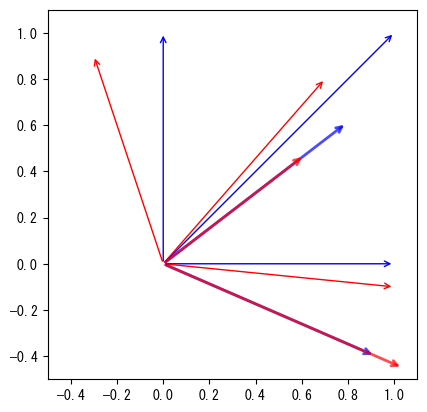

In [17]:
points = np.array([[0, 1.0], [1.0, 0], [1, 1]])


def draw_arrows(points, **kw):
    props = dict(color="blue", arrowstyle="->")
    props.update(kw)
    for x, y in points:
        plt.annotate(
            "",
            xy=(x, y),
            xycoords="data",
            xytext=(0, 0),
            textcoords="data",
            arrowprops=props,
        )


draw_arrows(points)
draw_arrows(np.dot(A, points.T).T, color="red")
draw_arrows(evectors.T, alpha=0.7, linewidth=2)
draw_arrows(np.dot(A, evectors).T, color="red", alpha=0.7, linewidth=2)

ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlim(-0.5, 1.1)
ax.set_ylim(-0.5, 1.1);

`numpy.linalg`モジュールにも`eig()`がありますが、`scipy.linalg`モジュールの`eig()`は一般化された固有値と一般化された固有ベクトルを計算することをサポートしています。これらは以下の等式を満たし、$\mathbf{B}$は$n \times n$の行列です：

$$\mathbf{A}\mathbf{x} = \lambda \mathbf{B} \mathbf{x} $$

一般化された固有ベクトルは、楕円フィッティングに使用できます。楕円フィッティングの式と原理については、以下の論文を参照してください：

```{seealso}
http://research.microsoft.com/pubs/67845/ellipse-pami.pdf

一般化された固有ベクトルを使用して楕円フィッティングを計算します。
```

楕円上の点は以下の方程式を満たします。ここで、$a,b,c,d,e,f$は楕円のパラメータであり、$(x, y)$は平面上の座標点です：

$$f(x, y) = a x^2 + b x y + c y^2 + d x + e y + f = 0$$

楕円フィッティングとは、平面上の点$(x_i, y_i)$の集合が与えられたとき、$\sum{f(x_i, y_i)^2}$が最小となる楕円のパラメータを見つけることです。これは明らかに最小化問題であり、前節で紹介した最適化アルゴリズム`optimize.least_squares()`を使用して解くことができます。パラメータがすべて0になる自明な解を避けるために、少しの工夫が必要です。以下に、論文で使用されている一般化固有ベクトルを用いた楕円フィッティングの方法を示します。

まず、$\mathbf{x_i} = [x_i^2, x_i y_i, y_i^2, x_i, y_i, 1]^T$、$\mathbf{D}=[\mathbf{x}_1, \dots ,\mathbf{x}_n]$と定義します。$\mathbf{D}$は$n \times 6$の行列であり、$n$は点の数です。$\mathbf{D}$の各行は座標点に対応します。$\mathbf{a}$はフィッティング楕円の係数です：$\mathbf{a} = [a, b, c, d, e, f]^T$。すると、$\mathbf{a}$は以下の方程式を満たします：

$$\mathbf{D}^T \mathbf{D} \mathbf{a} = \lambda \mathbf{C} \mathbf{a}$$ 

ここで、$\mathbf{C}$は$6 \times 6$の行列です：

$$\mathbf{C} = \begin{bmatrix}
0 &0  &2  &0  &0  & 0\\ 
0 &-1  &0  &0  &0  &0 \\ 
2 &0  &0  &0  &0  &0 \\ 
0 &0 &0  &0  &0  &0 \\ 
0 &0  &0  &0  &0  &0 \\ 
0 &0  &0  &0  &0  &0 
\end{bmatrix}$$

明らかに、この式は一般化固有ベクトルの等式に従っているため、`linalg.eig()`を使用して解くことができます。以下に、楕円のパラメータ方程式を使用して、ある楕円上のランダムな60点を計算し、ランダムなノイズを加える方法を示します：

$$X(t)=X_c + a\,\cos t\,\cos \varphi - b\,\sin t\,\sin\varphi$$
$$Y(t)=Y_c + a\,\cos t\,\sin \varphi + b\,\sin t\,\cos\varphi$$

In [96]:
np.random.seed(1)
t = np.random.uniform(0, np.pi * 0.8, 60)

alpha = 0.2
a = 1.5
b = 1.0
x = 1.0 + a * np.cos(t) * np.cos(alpha) - b * np.sin(t) * np.sin(alpha)
y = 1.0 + a * np.cos(t) * np.sin(alpha) - b * np.sin(t) * np.cos(alpha)
x += np.random.normal(0, 0.01, size=len(x))
y += np.random.normal(0, 0.01, size=len(y))

❶2番目の引数を渡すと、`eig()`は一般化固有値とベクトルを計算します。`evectors`には6つの固有ベクトルが含まれており、❷これらの6つの固有ベクトルを楕円方程式に代入して平均誤差を計算し、❸誤差が最小の固有ベクトルを楕円のパラメータ`p`として選択します。次のグラフは、パラメータ`p`が表す楕円とデータ点を示しています。

In [97]:
D = np.c_[x**2, x * y, y**2, x, y, np.ones_like(x)]
A = np.dot(D.T, D)
C = np.zeros((6, 6))
C[[0, 1, 2], [2, 1, 0]] = 2, -1, 2
evalues, evectors = linalg.eig(A, C)  # ❶
evectors = np.real(evectors)
err = np.max(np.dot(D, evectors) ** 2, 0)  # ❷
p = evectors[:, np.argmin(err)]  # ❸
print(p)

[ 0.24816637 -0.30638538  0.52527515 -0.19729622 -0.72762932  0.01603882]


In [100]:
err

array([6.21552602e-02, 4.37838086e-04, 5.74201000e-03, 4.10835267e+00,
       2.03500479e-01, 1.44780133e+00])

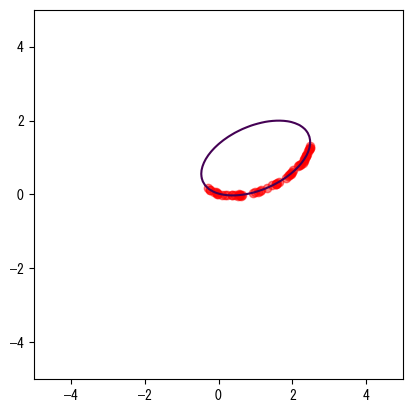

In [101]:
def ellipse(p, x, y):
    a, b, c, d, e, f = p
    return a * x**2 + b * x * y + c * y**2 + d * x + e * y + f


X, Y = np.mgrid[-5:5:100j, -5:5:100j]
Z = ellipse(p, X, Y)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(x, y, "ro", alpha=0.5)
ax.contour(X, Y, Z, levels=[0]);

In [102]:
from scipy import optimize

In [103]:
def ellipse_pars(a, b, theta, x0, y0):
    A = a**2 * np.sin(theta) ** 2 + b**2 * np.cos(theta) ** 2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta) ** 2 + b**2 * np.sin(theta) ** 2
    D = -2 * A * x0 - B * y0
    E = -B * x0 - 2 * C * y0
    F = A * x0**2 + B * x0 * y0 + C * y0**2 - a**2 * b**2
    return A, B, C, D, E, F


def err(p, x, y):
    p2 = ellipse_pars(*p)
    return np.mean(np.abs(ellipse(p2, x, y)))


# np.random.seed(42)
# t = np.random.uniform(0, np.pi, 60)

# alpha = 0
# a = 2.5
# b = 2.0
x = 1.0 + a * np.cos(t) * np.cos(alpha) - b * np.sin(t) * np.sin(alpha)
y = 1.0 + a * np.cos(t) * np.sin(alpha) - b * np.sin(t) * np.cos(alpha)
x += np.random.normal(0, 0.01, size=len(x))
y += np.random.normal(0, 0.01, size=len(y))

r = optimize.minimize(
    err,
    [3, 3, 0, 1, 1],
    args=(x, y),
    method="SLSQP",
    constraints=[
        dict(type="ineq", fun=lambda p: p[0] - 0.5),
        dict(type="ineq", fun=lambda p: p[1] - 0.5),
    ],
)
print(r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.025452243057544535
       x: [ 1.486e+00  6.932e-01  4.126e-01  1.067e+00  8.405e-01]
     nit: 49
     jac: [-7.723e-03 -1.215e-02  1.518e-02 -3.119e-02  6.019e-03]
    nfev: 327
    njev: 49


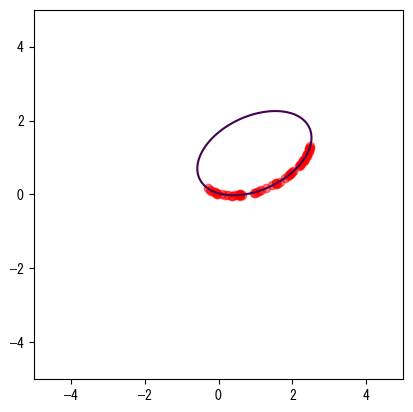

In [104]:
r = optimize.differential_evolution(
    err, bounds=[(1, 10), (1, 10), (-np.pi, np.pi), (-10, 10), (-10, 10)], args=(x, y)
)

X, Y = np.mgrid[-5:5:100j, -5:5:100j]
Z = ellipse(ellipse_pars(*r.x), X, Y)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(x, y, "ro", alpha=0.5)
ax.contour(X, Y, Z, levels=[0]);

## 特異値分解-SVD

特異値分解は線形代数における重要な行列分解であり、信号処理、統計学などの分野で重要な応用があります。$\mathbf{M}$が$m \times n$次の行列であると仮定すると、分解$M = \mathbf{U}  \mathbf{\Sigma} \mathbf{V^{*}}$が存在します。ここで、$\mathbf{U}$は$m \times m$次のユニタリ行列、$\mathbf{\Sigma}$は半正定値$m \times n$次の対角行列、$\mathbf{V^{*}}$は$\mathbf{V}$の共役転置であり、$n \times n$次のユニタリ行列です。このような分解を$\mathbf{M}$の特異値分解と呼びます。$\mathbf{\Sigma}$の対角要素は$\mathbf{M}$の特異値です。通常、特異値は大きい順に並べられます。

特異値の数学的記述は少し難解ですが、具体的な例を通じて特異値分解の用途を説明します。以下の例では、グレースケール画像に対して特異値分解を行い、分解された3つの行列から特異値が大きい部分のデータを抽出して元の画像を復元します。まず、画像を読み込み、赤、緑、青の3つのチャンネルからグレースケール画像`img`を計算します。画像の幅は375ピクセル、高さは505ピクセルです。

In [27]:
r, g, b = np.rollaxis(plt.imread("data/vinci_target.png"), 2).astype(float)
img = 0.2989 * r + 0.5870 * g + 0.1140 * b
img.shape

(505, 375)

`scipy.linalg.svd()`を呼び出して画像行列を特異値分解し、3つの分解部分を得ます：

* `U`: 式の$\mathbf{U}$に対応します；

* `s`: 式の$\mathbf{\Sigma}$に対応します。$\mathbf{\Sigma}$は対角行列であり、対角要素のみが非ゼロであるため、`s`は対角要素のみを保存する1次元配列です。

* `Vh`: 式の$\mathbf{V^{*}}$に対応します。

In [28]:
U, s, Vh = linalg.svd(img)
%C 5 U.shape; s.shape; Vh.shape

 U.shape       s.shape      Vh.shape 
----------     -------     ----------
(505, 505)     (375,)      (375, 375)


`s`の各値は`Vh`の行ベクトルおよび`U`の列ベクトルに対応し、デフォルトでは大きい順に並べられます。これは対応するベクトルの重要性を示します。次のグラフからわかるように、`s`の特異値の大きさは大きく異なります。Y軸は対数スケールであることに注意してください。

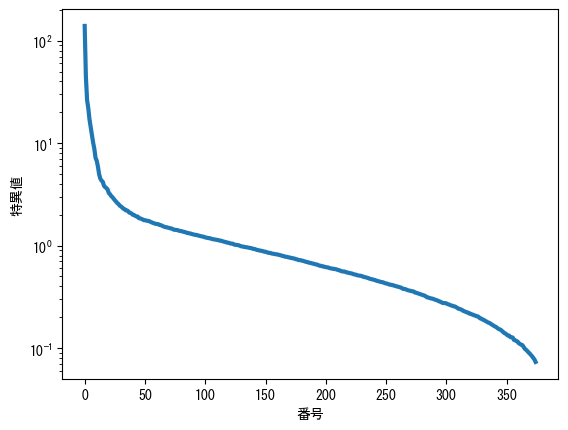

In [29]:
plt.semilogy(s, lw=3)
plt.xlabel("番号")
plt.ylabel("特異値");

以下の`composite()`は、`U`と`Vh`の最初の`n`個のベクトルを選択して行列を再合成します。すべてのベクトルを使用すると、再合成された行列は元の行列と同じになります：

In [30]:
def composite(U, s, Vh, n):
    return U[:, :n] @ (s[:n, None] * Vh[:n, :])


np.allclose(img, composite(U, s, Vh, len(s)))

True

以下に、最初の10個、20個、および50個のベクトルを使用して合成した結果を示します。次のグラフに示すように、使用するベクトルが多いほど、結果は元の画像に近づきます：

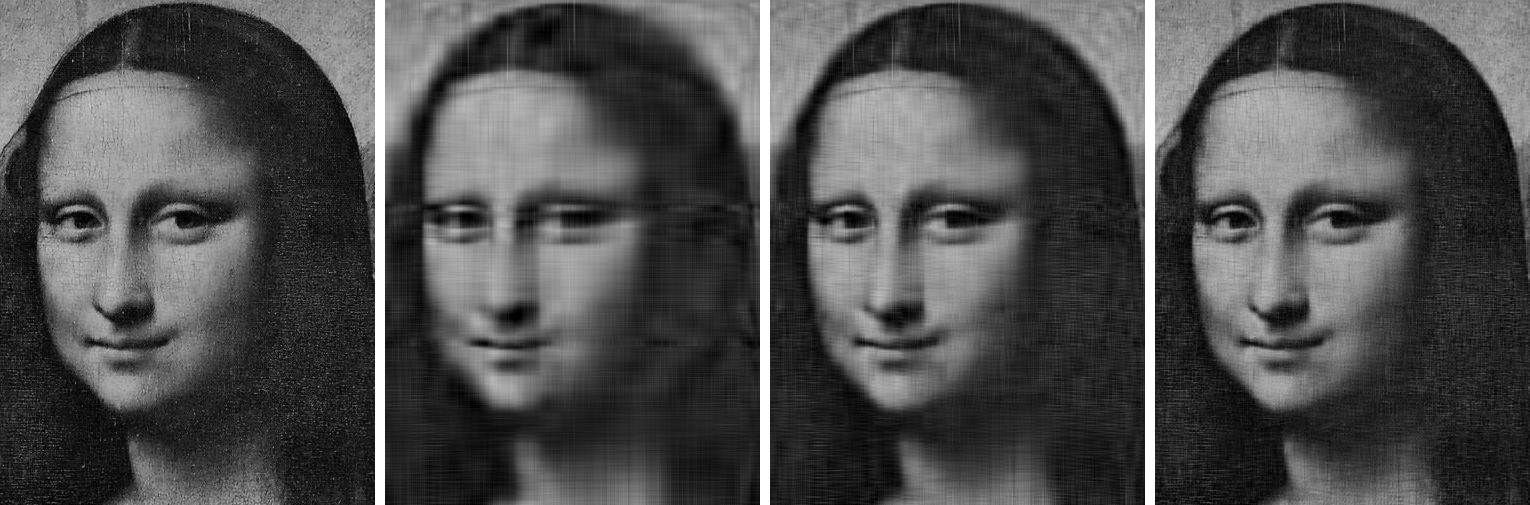

In [31]:
img10 = composite(U, s, Vh, 10)
img20 = composite(U, s, Vh, 20)
img50 = composite(U, s, Vh, 50)

from helper.numpy import array_image

array_image(img, img10, img20, img50)